# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. 

# Objetivo

Generar y entrenar un modelo para detectar las críticas negativas de forma automática. El modelo deberá alcanzar un valor F1 de al menos 0.85.



# Recursos

Se proporciona un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas.

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

## Inicialización

In [4]:
pip install contractions

     |████████████████████████████████| 289 kB 31.8 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 67.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import math

import numpy as np
import pandas as pd
import re
import contractions

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics

import nltk
import spacy
import torch
import transformers

from tqdm.auto import tqdm

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from lightgbm import LGBMClassifier

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [7]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [8]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
display(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [11]:
print(f'El número total de filas duplicadas en este archivo es de {df_reviews.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


In [12]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


<AxesSubplot:xlabel='pos', ylabel='count'>

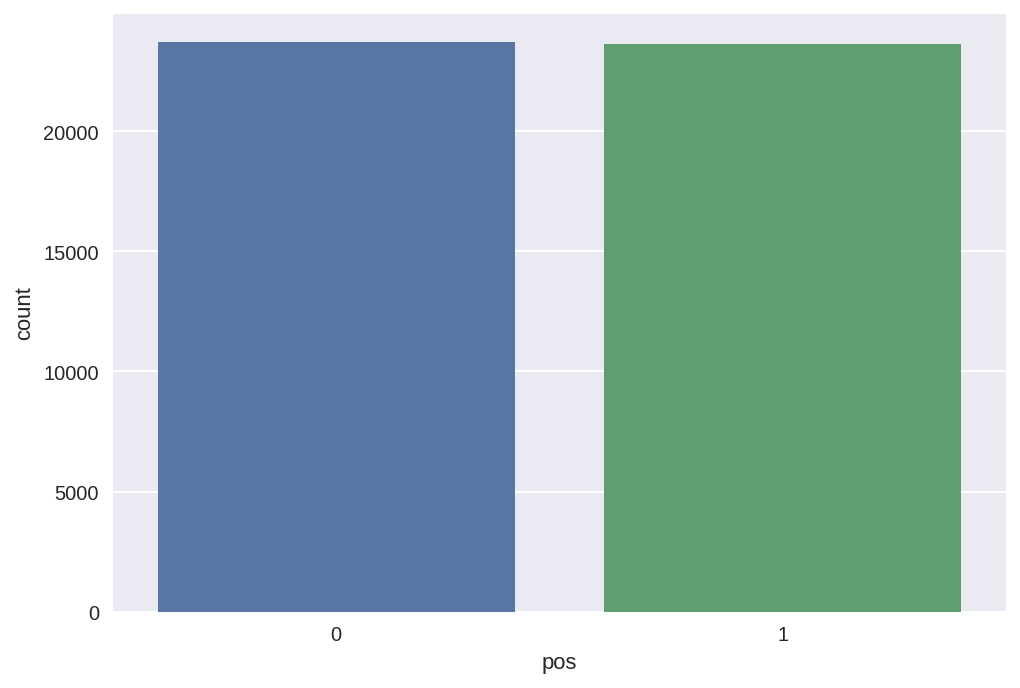

In [13]:
sns.countplot(x="pos", data=df_reviews)

In [14]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

En una revisión de los datos se pudo observar:

    El dataset cuenta con 47331 opiniones y no cuenta con filas duplicadas.

    Sólo faltan 2 opiniones con valoración_media y votos, sin embargo no se procede a tratar estos datos, debido a que no forman parte de nuestras columnas objetivo.

    Los datos de la columna objetivo es equilibrado.

    El rango de fechas va del 1894 al 2010

    La valoración media de una categoría es aproximadamente 6, siendo 1.4 lo más bajo y 9.7 lo más alto

    El número de votos oscila entre 9 y 1,7 millones de votos.

    El rating oscila entre 1 y 10.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

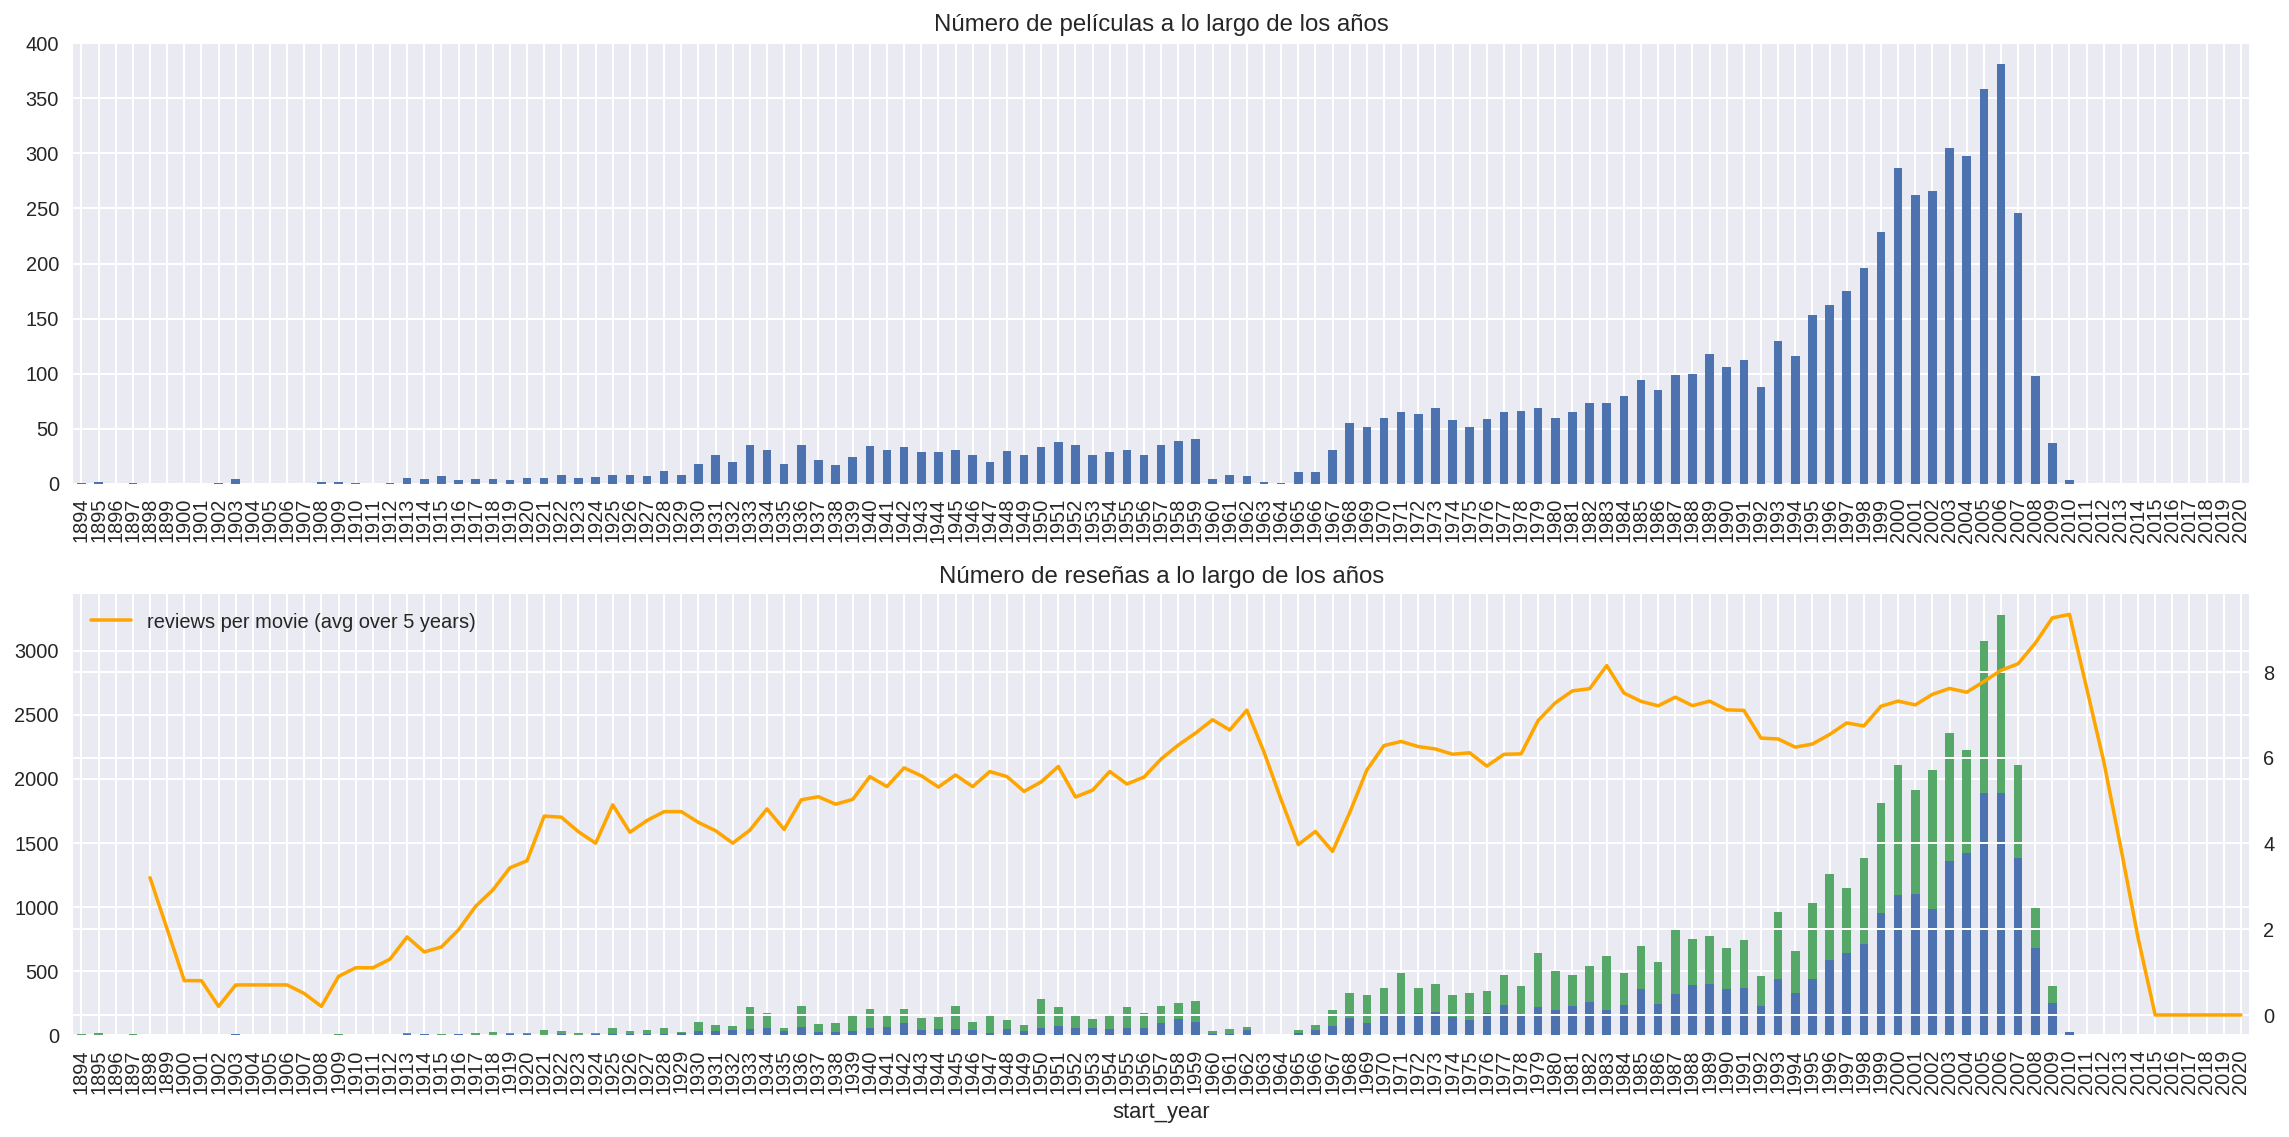

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Número de películas a lo largo de los años
    
    - En el eje x se tiene representado el tiempo en años y, en el eje y se tiene regristrado el número de películas, para así poder apreciar el número de peliculas a lo largo de los años. 

Número de reseñas a lo largo de los años
      
    - Se observa en el eje x el tiempo por años, y en el eje y el número de reseñas de películas a lo largo de los años utilizando un gráfico de barras apiladas y una línea que muestra el promedio móvil de reseñas por película a lo largo de los años
    
El año con mayor número de películas estrenadas y comentadas fue el 2006.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

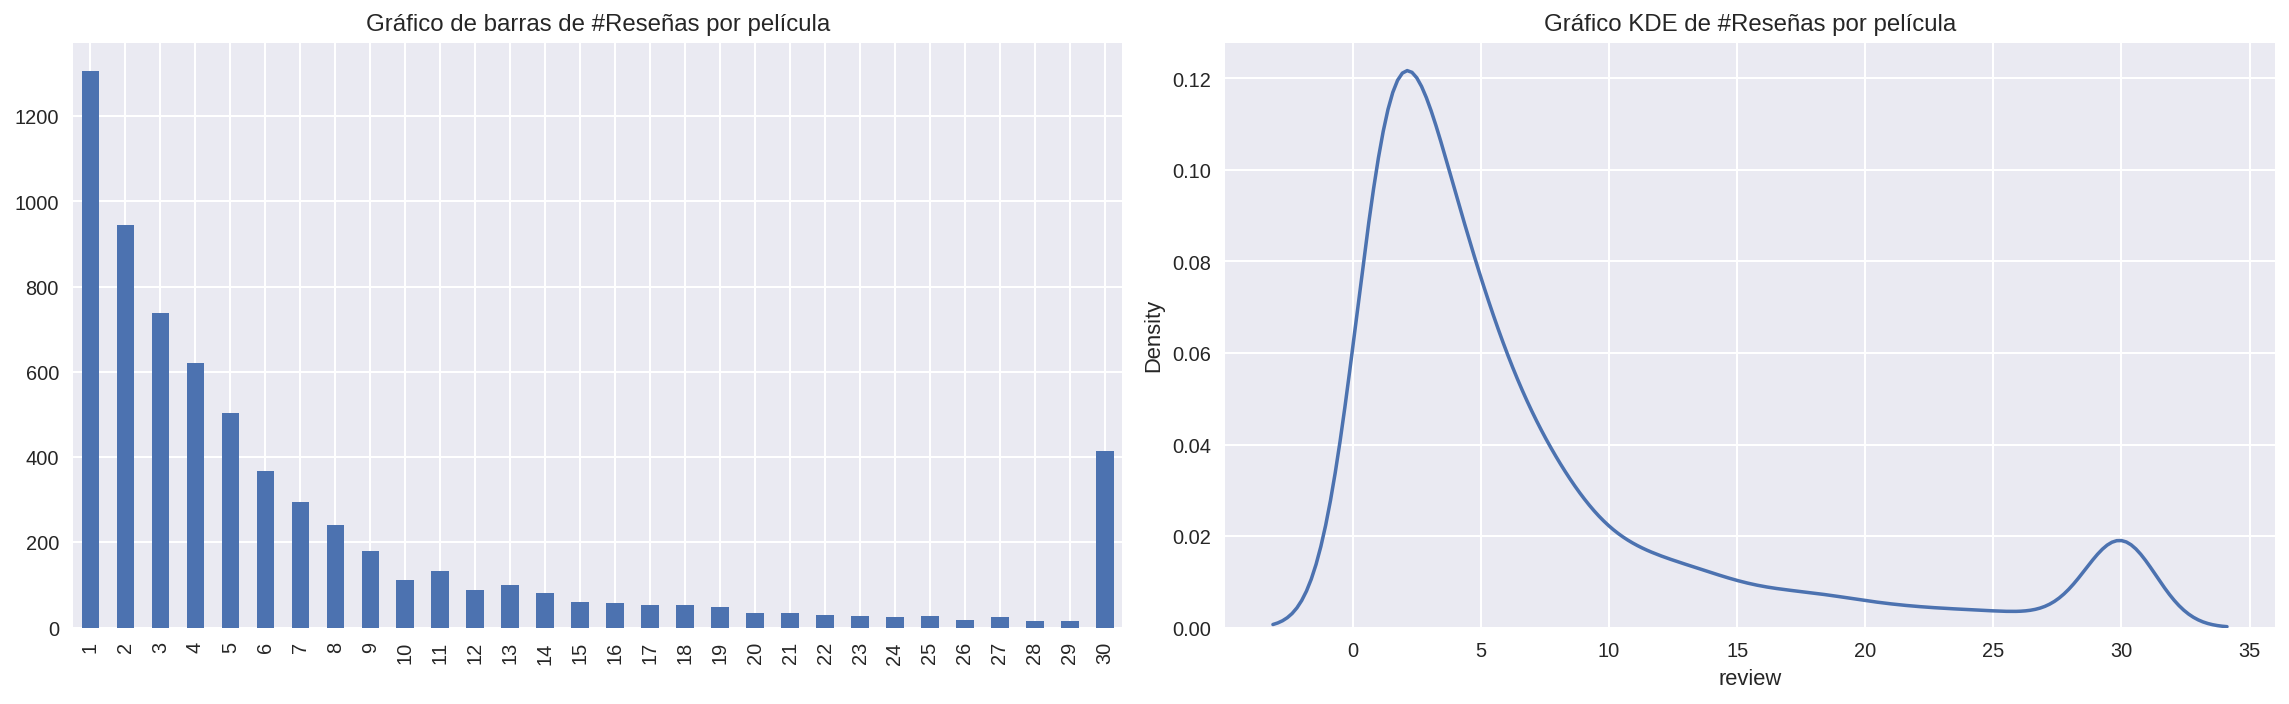

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Gráfico de barras de #Reseñas por película:

    - se observa la distribución del número de reseñas por pelicula, siendo el eje X el número de reseñas por película, mientras que el eje y representa el recuento de peliculas que tienen ese número específico de reseñas. La cantidad de péliculas que tienen al menos 1 reseña es el dato que más presencia tiene en nuestro dataset, posterior a eso, el número de reviews 

Gráfico KDE de #Reseñas por película: 
    
    - El gráfico KDE (Kernel Density Estimation) muestra cómo se distribuyen los números de reseñas por película en el dataset. En el eje horizontal (x), se tiene representado el número de reseñas por película. En el eje vertical (y), se tiene la densidad de probabilidad estimada para cada valor de número de reseñas. Observando en el gráfico que hay mayores probabilidades que las películas tengan al menos 1 review y de ahí vayan decreciendo, hasta llegar a 30, donde se observa una nueva subida ligera. 
    

A pesar de que la gran mayoría de las películas, solo tienen 1 solo review, existen un poco mas de 400 películas que obtuvieron 30 reviews.

In [17]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

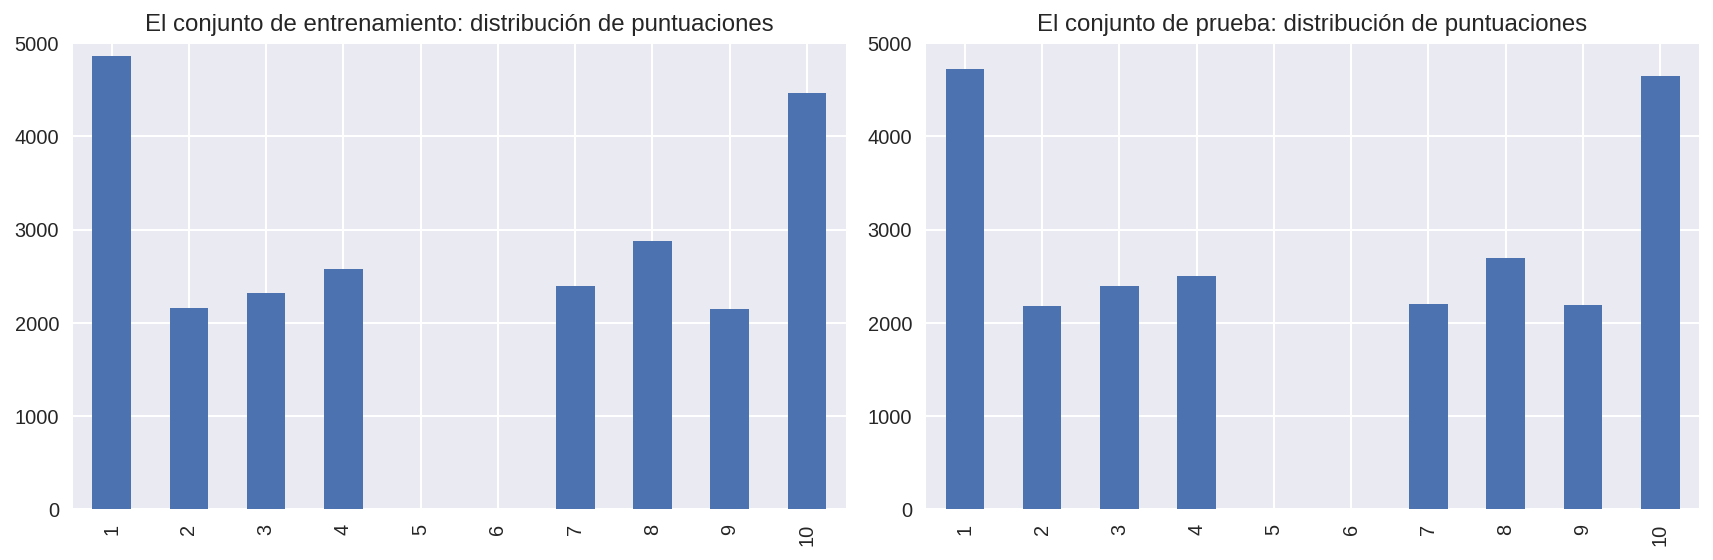

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Gráfico El conjunto de entrenamiento: distribución de puntuaciones:

    -  muestra la distribución de puntuaciones para el conjunto de datos de entrenamiento, donde el eje y muestra el recuento de películas con cada puntuación, y el eje x muestra las puntuaciones.

Gráfico, El conjunto de prueba: distribución de puntuaciones:

    -  muestra la distribución de puntuaciones en el conjunto de prueba en lugar del conjunto de entrenamiento.
    
Por lo que vemos una distribución relativamente parecida en ambos sets.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


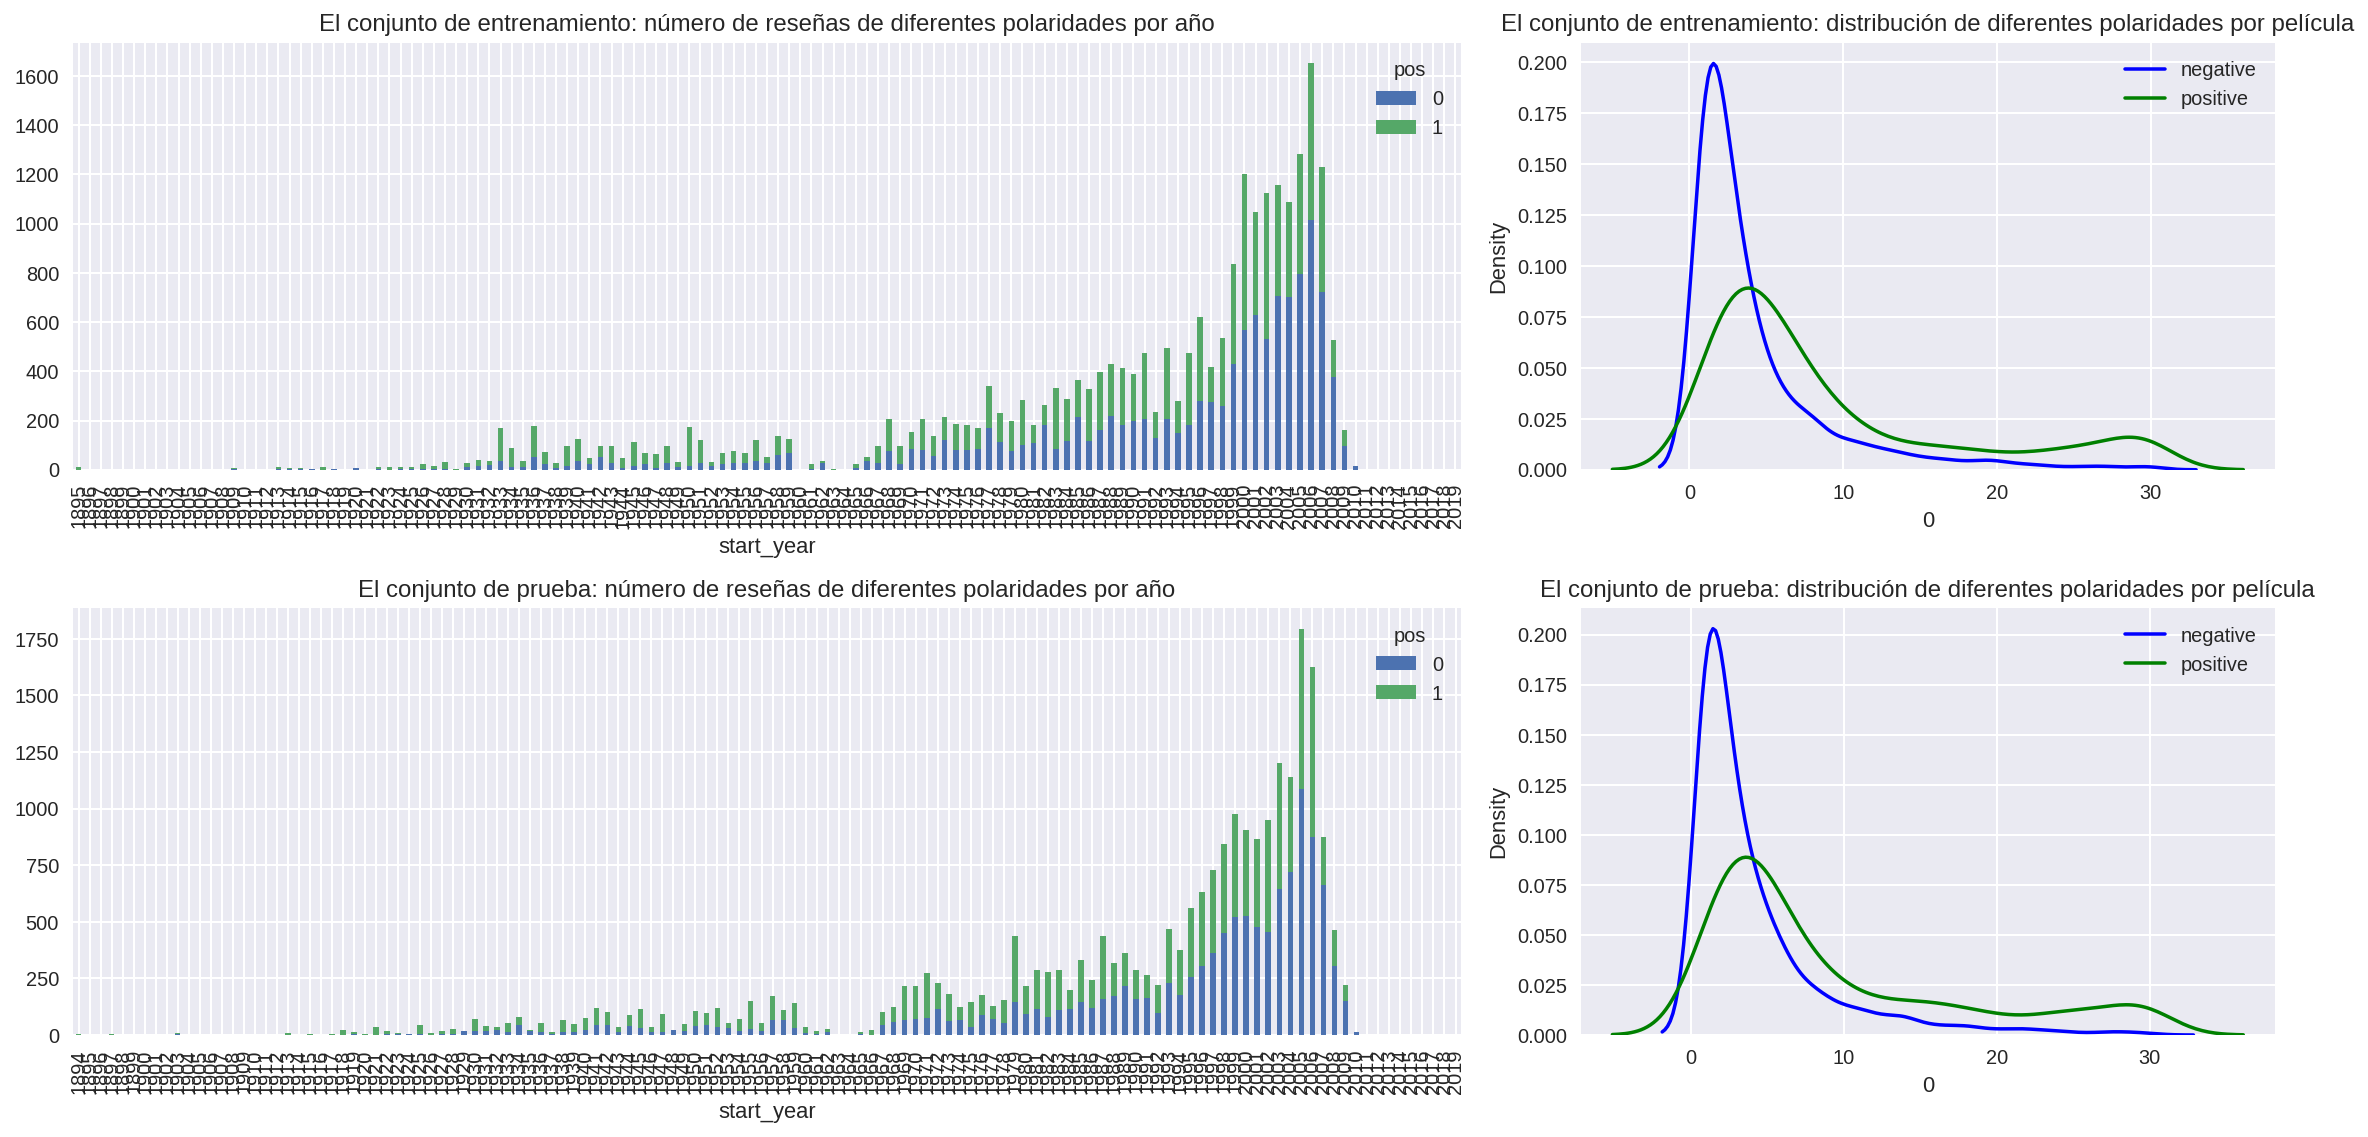

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se presentan gráficos por set de entrenamiento y por set de test.

Una de las gráficas se representa el número de reseñas de diferentes polaridades por año, mostrando en los datos en azul con el número 0 representando el número de reseñas negativas por película y el verde con el número 1 representando el número de reseñas positivas por película.

En el segundo gráfico por se visualiza la distribución de diferentes polaridades de reseñas por película, el eje x muestra el rango de valores de la variable (número de reseñas por película) y el eje y muestra la densidad de probabilidad estimada para cada valor en ese rango. 

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [20]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [21]:
def clear_text(text):
    text = text.lower()
    text = contractions.fix(text)
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    return clean_text

df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

print(df_reviews['review_norm'].head())

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i am totally agree with garryjohal from singap...
Name: review_norm, dtype: object


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [23]:
df_reviews_train

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlson's raiders is more o...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled 'balderdash ' little i...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie 'gung ho ' the story of carlson's ma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47253,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,O my gosh... Just give me a minute to breath. ...,10,pos,1,train,407,o my gosh just give me a minute to breath this...
47254,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,I can't tell you all how much I love this movi...,10,pos,1,train,408,i cannot tell you all how much i love this mov...
47255,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,Legend of Zu is possibly the most exciting mov...,10,pos,1,train,409,legend of zu is possibly the most exciting mov...
47256,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,This movie is well done on so many levels that...,10,pos,1,train,411,this movie is well done on so many levels that...


## Trabajar con modelos

### Modelo 0 - Constante

Se trabaja con un modelo dummy, con el objetivo de tenerlo como referencia y poder comprarlo con los demás modelos.

In [24]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))


def tokenize_and_lemmatize(text, lemmatizer, stop_words):
    tokens = word_tokenize(text)
    tokens_stop = [token for token in tokens if not token in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens_stop]
    lemmas_joined = " ".join(lemmas)
    return lemmas_joined

In [25]:
train_features = df_reviews_train['review_norm'].apply(tokenize_and_lemmatize, args=(lemmatizer, stop_words))

test_features = df_reviews_test['review_norm'].apply(tokenize_and_lemmatize, args=(lemmatizer, stop_words))

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


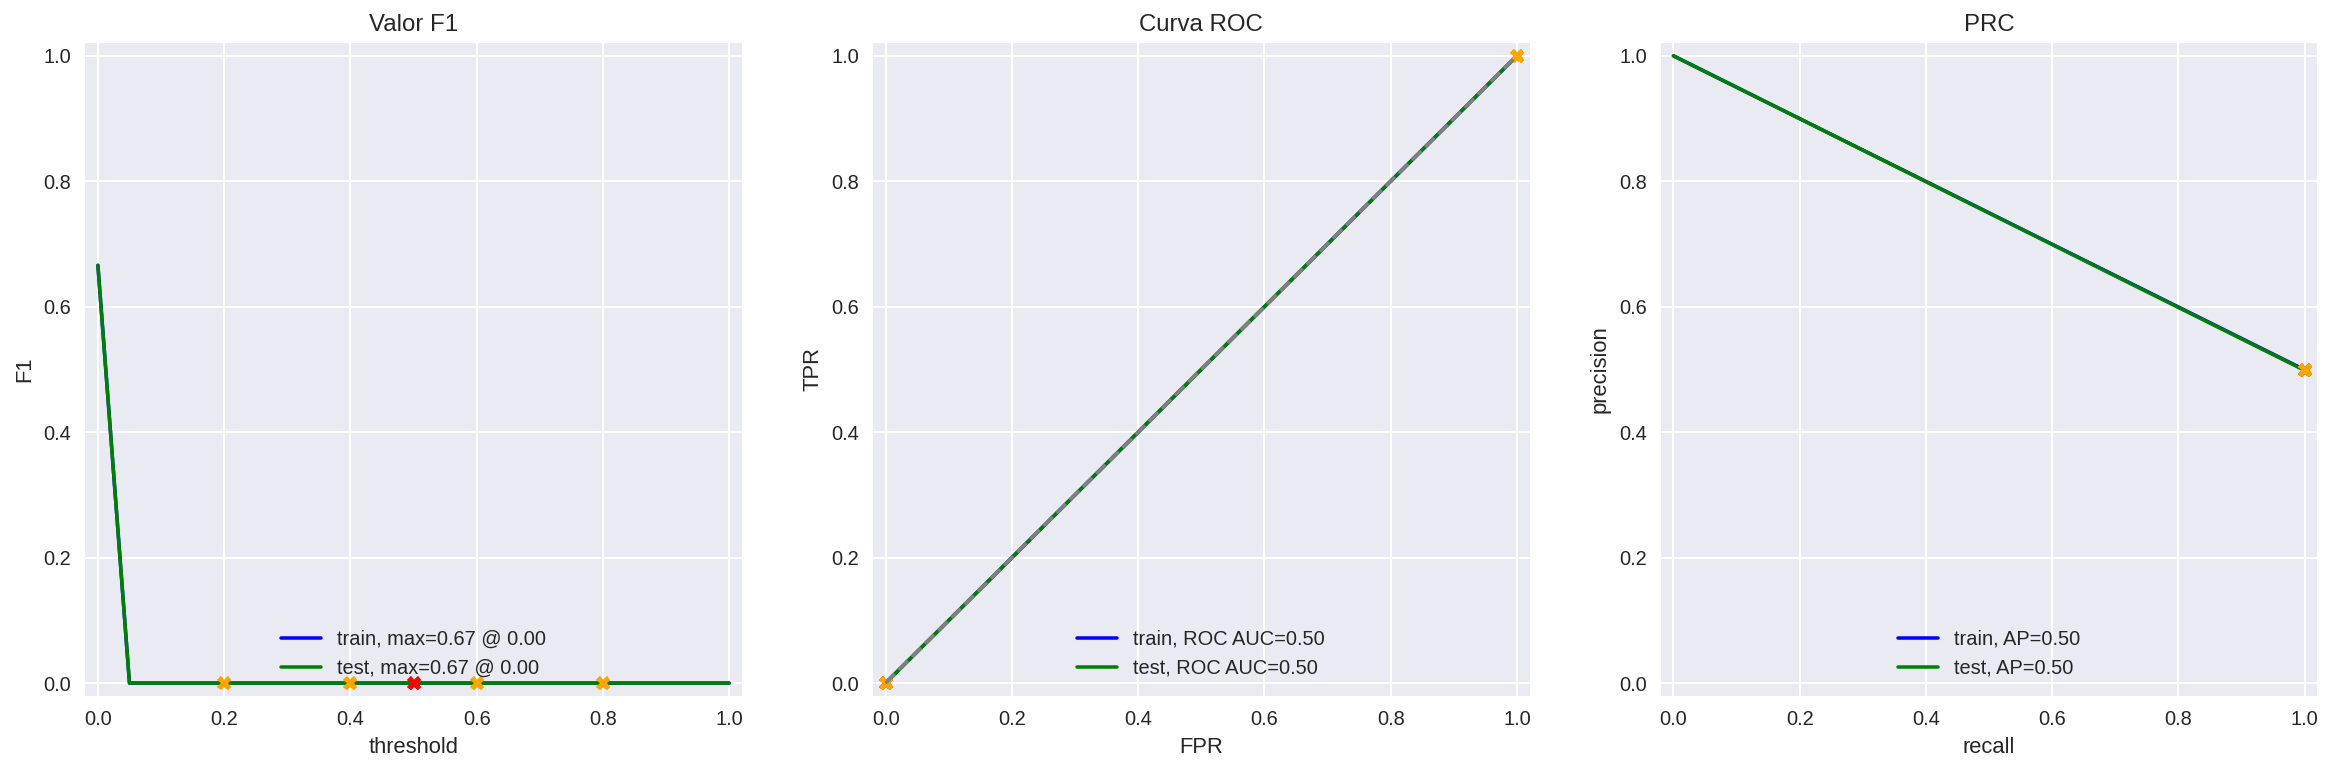

In [26]:
model_0 = DummyClassifier(strategy="most_frequent")
model_0.fit(train_features, train_target)

evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [27]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=list(stop_words))

train_features_2 = tfidf_vectorizer_2.fit_transform(train_features) 
test_features_2 = tfidf_vectorizer_2.transform(test_features) 

model_2 = LogisticRegression(random_state=12345) 
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


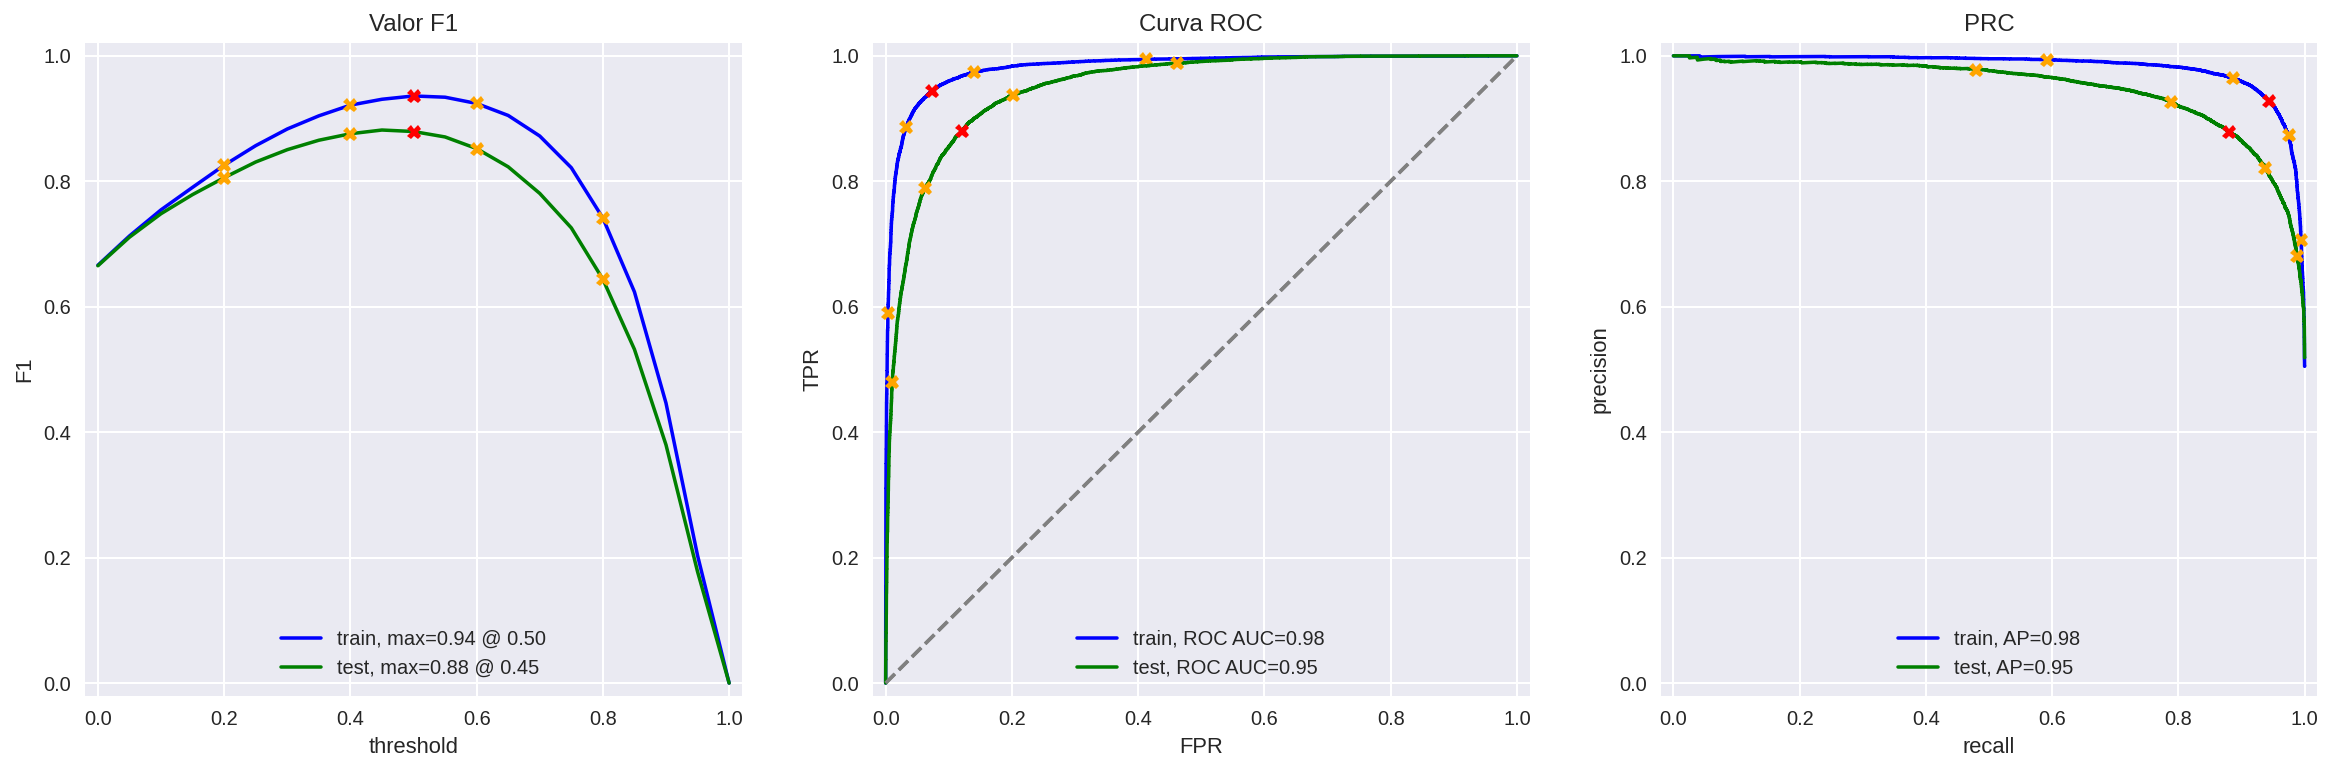

In [28]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [29]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def lemmatize(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [31]:
train_spacy3 = df_reviews_train['review_norm'].apply(lemmatize)
test_spacy3 = df_reviews_test['review_norm'].apply(lemmatize)

tfidf_vectorizer_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorizer_3.fit_transform(train_spacy3) 
test_features_3 = tfidf_vectorizer_3.transform(test_spacy3) 

In [32]:
model_3 = LogisticRegression(random_state=12345) 
model_3.fit(train_features_3, train_target)

LogisticRegression(random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


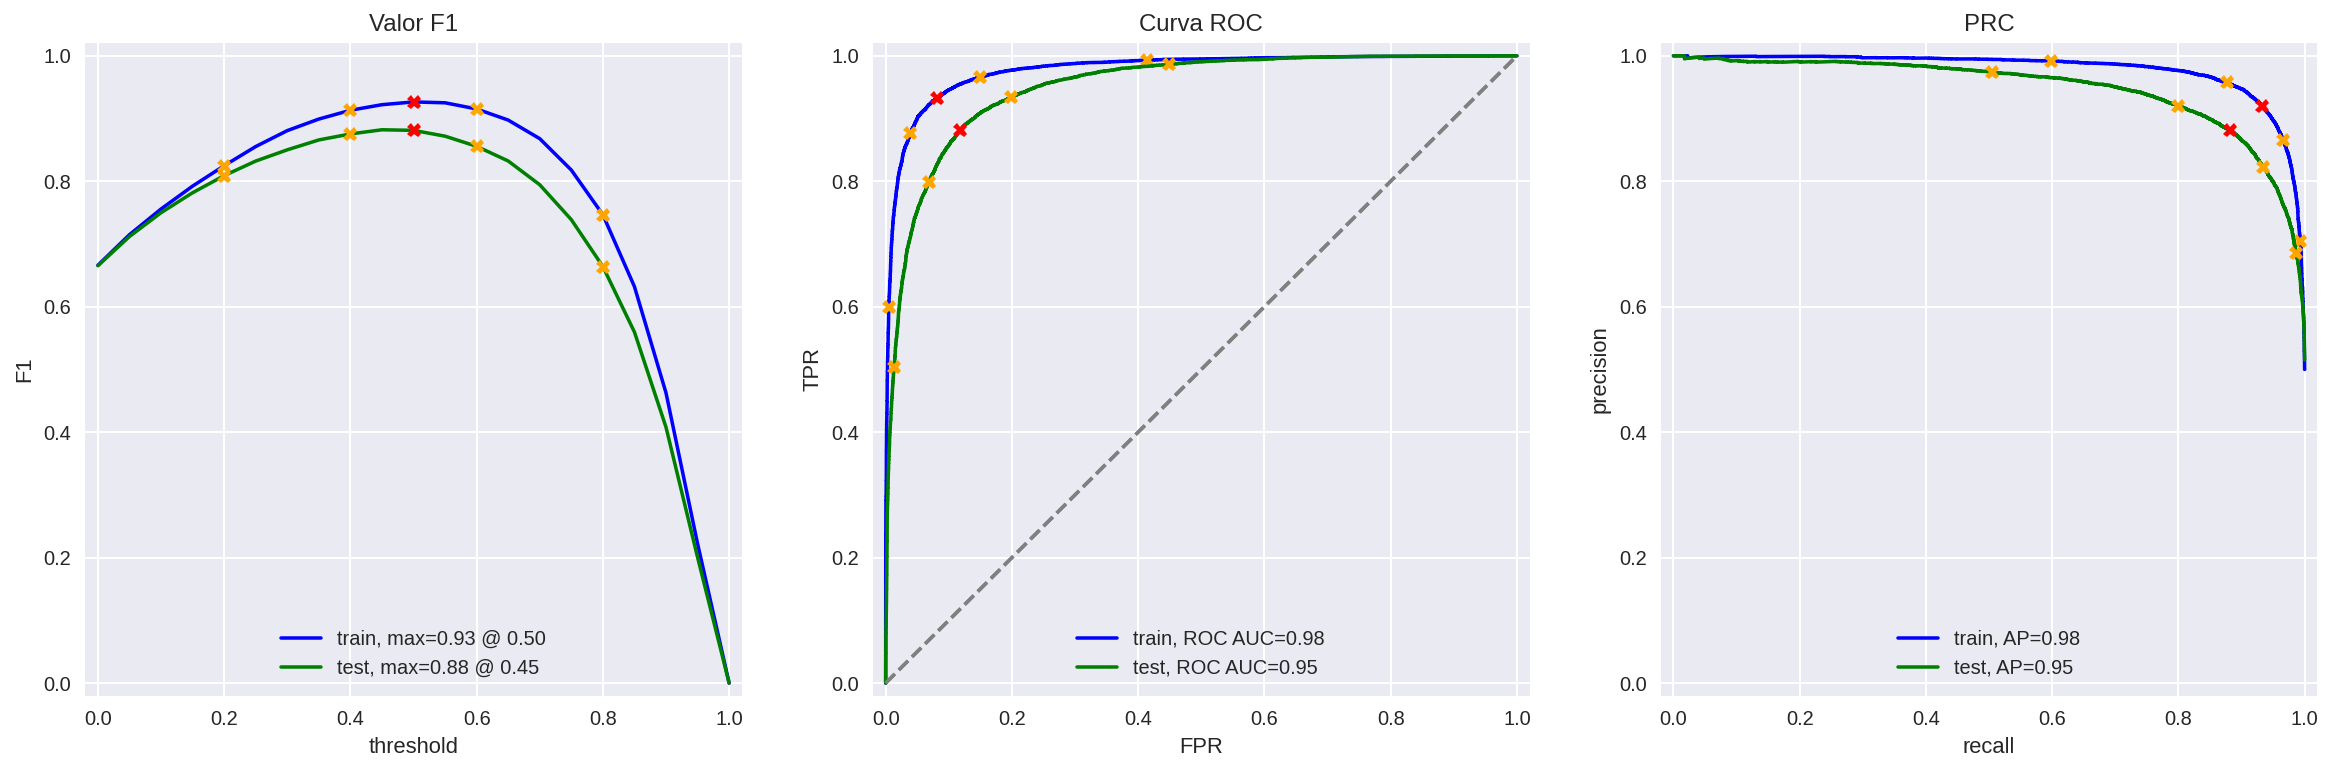

In [33]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [34]:
# Definir los parámetros para la búsqueda de cuadrícula
parameters = {
    'num_leaves': [10, 20],
    'learning_rate': [0.5, 0.1],
    'n_estimators': [10, 20, 40, 60],
    'objective': ['binary'],
    'random_state': [12345]
}

grid = GridSearchCV(estimator=LGBMClassifier(), param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_3, train_target)

model_4 = grid.best_estimator_
model_4.fit(train_features_3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=60, num_leaves=10,
               objective='binary', random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


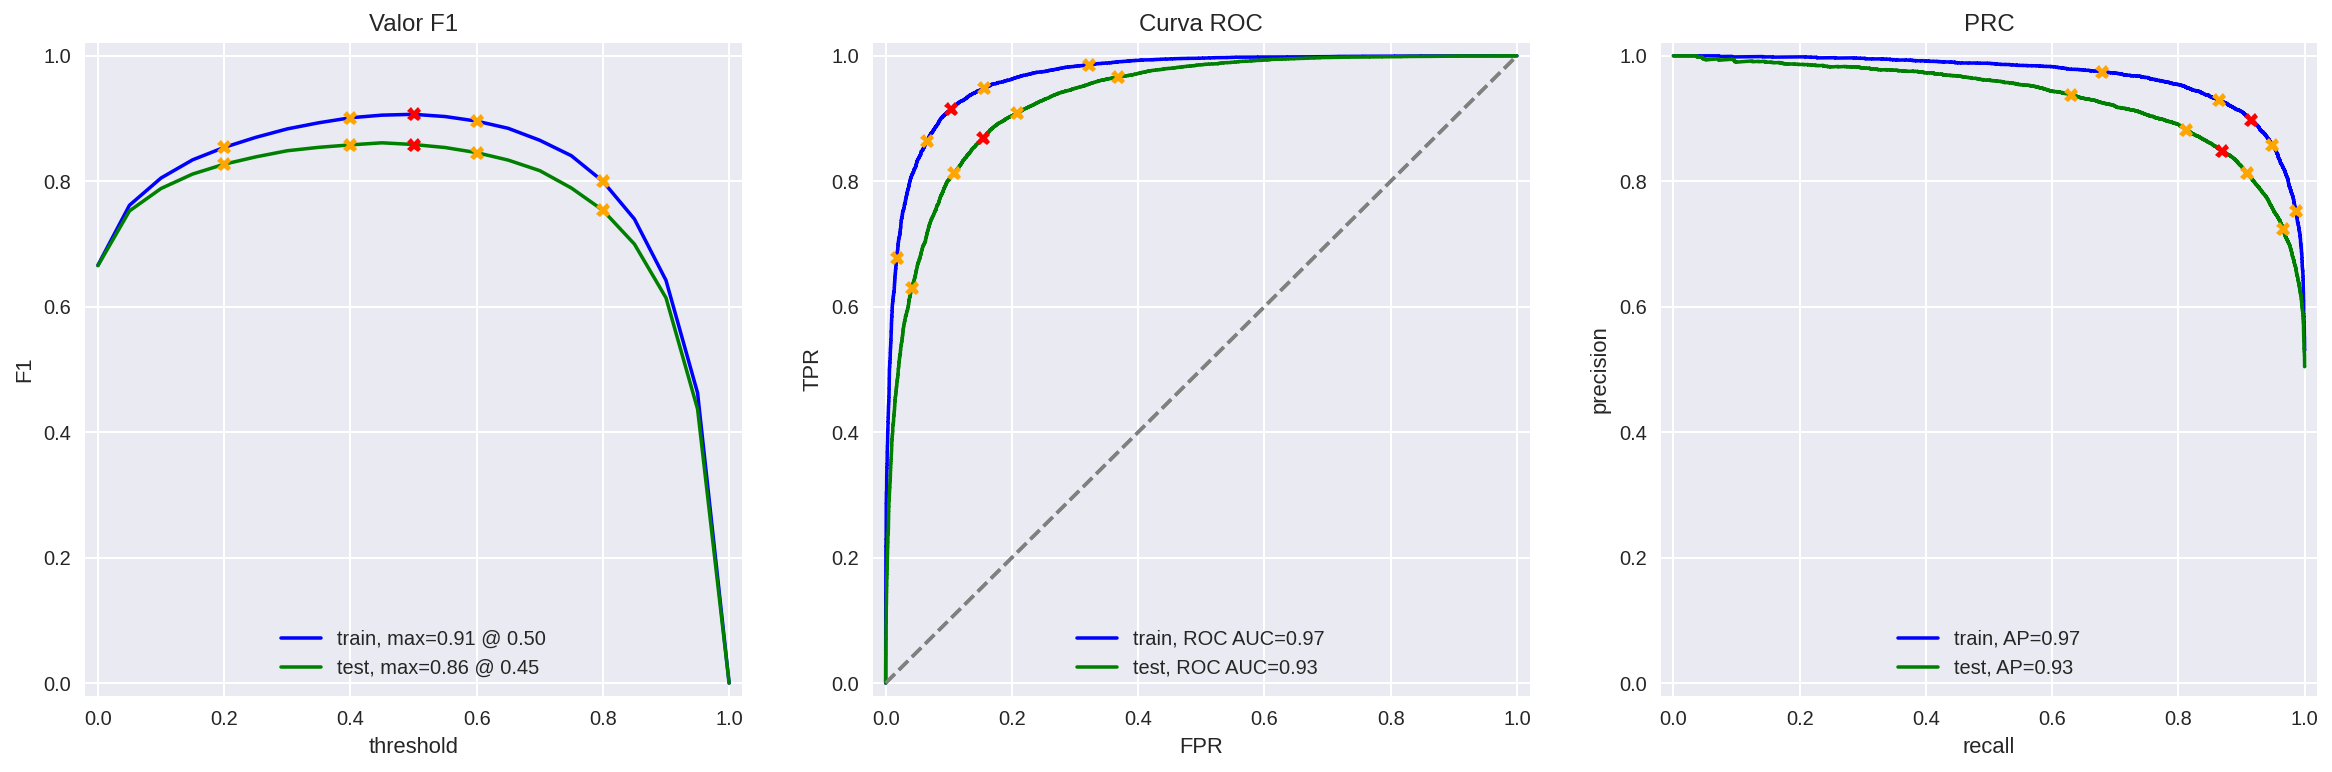

In [35]:
# Evaluar el mejor modelo en los datos de entrenamiento y prueba
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - BERT

Por cuestiones de mi computadora, no se pudo realizar el modelo Bert

'''
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
'''

'''def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)
'''

¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

y cargar...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

## Mis reseñas

In [38]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i did not expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Reviews positivos

- 2
- 4
- 5
- 7


Reviwes negativos:

- 0
- 1
- 3
- 6


Sabiendo esto, se hará una verificación de los resultados obtenidos por los modelos entrenados.
Recordando:

    - Positivo 1
    - Negativo 0

### Modelo 2

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.37:  i did not expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall it is a decent flick i could see mys
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Tabla comparativa utilizando modelo 2 - NLTK, TF-IDF y LR**

Índice | Original | Prediction 
--- |--- | ---  
0 | 0 | 0 
1 | 0 | 0 
2 | 1 | 1 
3 | 0 | 0 
4 | 1 | <span style="color:brown;font-weight:bold;"> 0 </span>
5 | 1 | <span style="color:brown;font-weight:bold;"> 0 </span>
6 | 0 | 0 
7 | 1 | 1 

Errando en el índice 4 y 5

### Modelo 3

In [41]:
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lemmatize)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i did not expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it is a decent flick i could see mys
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Tabla comparativa utilizando modelo 3 - spaCy, TF-IDF y LR**


Índice | Original | Prediction 
--- |--- | ---  
0 | 0 | 0 
1 | 0 | 0 
2 | 1 | <span style="color:brown;font-weight:bold;"> 0 </span> 
3 | 0 | 0 
4 | 1 | <span style="color:brown;font-weight:bold;"> 0 </span>
5 | 1 | 1
6 | 0 | 0 
7 | 1 | 1 

Errando en el índice 2 y 4

### Modelo 4

In [42]:
tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lemmatize)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.30:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.58:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.50:  i did not expect the reboot to be so good writers really cared about the source material
0.79:  the movie had its upsides and downsides but i feel like overall it is a decent flick i could see mys
0.21:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**Tabla comparativa utilizando modelo 4 - spaCy, TF-IDF y LGBMClassifier**

Índice | Original | Prediction 
--- |--- | ---  
0 | 0 | <span style="color:brown;font-weight:bold;"> 1 </span>  
1 | 0 | 0 
2 | 1 | 1 
3 | 0 | <span style="color:brown;font-weight:bold;"> 1 </span> 
4 | 1 | 1
5 | 1 | 1
6 | 0 | 0 
7 | 1 | 1 

Errando en el índice 0 y 3

### Modelo 9

no se pudo correr pero se conserva la sugerencia

'''
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
'''

## Conclusiones

El objetivo de este proyecto era desarrollar un modelo que clasificara las críticas de películas en positivas y negativas.

La puntuación F1 en el conjunto de pruebas debería ser de al menos 0.85.

Se lleva a cabo los siguientes pasos:

1.- Escrutineo de datos

2.- Revisión de la estadística descriptiva

3.- Preprocesamiento de datos (texto)

4.- EDA

5.- Preparación para los modelos

Los datos se dividieron en conjuntos de entrenamiento y de prueba casi por igual, de acuerdo con la división indicada ya en el dataset.


6.- Selección del modelo

Se trabaja con un modelo dummy para garantizar que los resultados tiene una eficiencia mejor que el simple azar. Los datos del modelo dummy fueron peores que el resto de los modelos trabajados.

Se trabajan con 3 modelos:
     
     - NLTK, TF-IDF y LR
     - spaCy, TF-IDF y LR
     - spaCy, TF-IDF y LGBMClassifier
     
Los 3 modelos logran superar el f1 solicitado. 

Respecto al rendimiento  de los modelos, se puede sugerir el modelo **NLTK, TF-IDF y LR que en general tuvo un mejor desempeño. 



 TfIdf + LR

El modelo con mejores métricas es el Modelo 1, este es un modelo de regresión logística que usa:

Natural Language Toolkit (NLTK) como libreria para la tokenización y lematización
valores TF-IDF como características